In [23]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import TensorDataset, DataLoader, StackDataset
from torch import nn
from torch_scatter import scatter_add
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

import sys
sys.path.append("..")
from training.dataset import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/cuisset/conda/envs/supercls-analyzer/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
input = InputSample("/workspaces/ticlRegression/runs/test-v1/24906.0_SinglePi_moreStats/histo.root")

In [3]:
input.caloparticles

<Array [{regressed_energy: [...], ...}, ...] type='999 * {regressed_energy:...'>

In [4]:
TEST_SIZE = 200
TRAIN_SIZE = len(input.tracksters_splitEndcaps) - TEST_SIZE
TRAIN_SIZE

1606

In [5]:
filteredInputSample = makeSelectedInputSample(input, 0, TRAIN_SIZE)

In [6]:
filteredInputSample.makeStackDataset().datasets["tracksterInEvent_idx"][1]

tensor([1., 1., 1.], dtype=torch.float64)

In [7]:
train_dataloader = makeDataLoader(filteredInputSample, batch_size=20)

In [8]:
(filteredInputSample.makeStackDataset().datasets["features"])[1605]

tensor([[  1.9367,   2.2597, 340.8682,   1.9367,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000]], dtype=torch.float64)

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 10, dtype=torch.float64),
            nn.Linear(10, 1, dtype=torch.float64),
        )

    def forward(self, x):
        return torch.squeeze(self.model(x), dim=1)
net = Network()
loss_fct = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-7)

In [10]:
data_batches = list(iter(train_dataloader))
data_batches

[{'features': tensor([[ 5.4648e+00, -2.2003e+00, -3.3416e+02,  5.4648e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.4371e+01, -2.3206e+00, -3.5762e+02,  1.0684e+01,  0.0000e+00,
            0.0000e+00,  3.2996e+00,  3.8771e-01,  0.0000e+00,  0.0000e+00],
          [ 1.3105e+00, -2.3671e+00, -3.7156e+02,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  1.3105e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.2015e+00, -2.3671e+00, -3.5501e+02,  1.2015e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 6.8830e+00, -2.7258e+00, -3.3041e+02,  6.8830e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.7987e+00, -2.6489e+00, -3.3229e+02,  8.7987e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.8617e-01, -2.6246e+00, -3.4978e+02,  8.8617e-01,  0.0000

In [30]:
def endcap_energy_pred(model, data_batch):
    return scatter_add(model(data_batch["features"]), data_batch["tracksterInEvent_idx"])
def computeLoss(model, data_batch):
    return loss_fct(endcap_energy_pred(model, data_batch), data_batch["cp_energy"])

In [12]:
data_batch = data_batches[-1]
net(data_batch["features"])

tensor([-1.2338, -1.9951, -0.7929, -1.4379, -1.5417, -1.8558,  1.1711, -2.2429,
        -0.7252, -1.9241], dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [13]:
scatter_add(net(data_batch["features"]), data_batch["tracksterInEvent_idx"])

tensor([-3.2289, -0.7929, -4.8354, -1.0717, -0.7252, -1.9241],
       dtype=torch.float64, grad_fn=<ScatterAddBackward0>)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    #model.train()
    for batch, data_batch in enumerate(dataloader):
        # Compute prediction and loss
        loss = loss_fn(model, data_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1 == 0:
            print(f"loss: {loss.item():>7f}")

In [18]:
train_loop(train_dataloader, net, computeLoss, optimizer)

loss: 3882.170901
loss: 3544.677129
loss: 1683.043644
loss: 1544.151117
loss: 1041.397983
loss: 1046.116521
loss: 712.580633
loss: 411.547086
loss: 564.618694
loss: 909.376006
loss: 495.584343
loss: 656.989637
loss: 423.566100
loss: 181.912242
loss: 531.795683
loss: 374.942499
loss: 453.473415
loss: 264.438869
loss: 286.365599
loss: 219.934379
loss: 406.707867
loss: 389.578396
loss: 410.481247
loss: 268.165679
loss: 238.144002
loss: 315.104490
loss: 450.494119
loss: 481.202685
loss: 585.410479
loss: 410.826950
loss: 281.227182
loss: 359.799714
loss: 252.245855
loss: 105.907936
loss: 417.989854
loss: 392.425096
loss: 502.600857
loss: 176.936348
loss: 327.765523
loss: 424.740308
loss: 370.069644
loss: 362.373088
loss: 229.373499
loss: 452.241935
loss: 328.330536
loss: 5416.649356
loss: 2591.643164
loss: 1181.119939
loss: 1568.375822
loss: 752.431299
loss: 661.257739
loss: 659.503945
loss: 350.870237
loss: 374.386442
loss: 952.445406
loss: 357.538195
loss: 713.134307
loss: 508.190774
loss

## Prediction

In [19]:
fullDataset = makeSelectedInputSample(input).makeStackDataset()

In [20]:
pred_loader = makeDataLoader(makeSelectedInputSample(input), batch_size=200000)
pred_batch = next(iter(pred_loader))
pred_batch

{'features': tensor([[ 5.4648e+00, -2.2003e+00, -3.3416e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.4371e+01, -2.3206e+00, -3.5762e+02,  ...,  3.8771e-01,
           0.0000e+00,  0.0000e+00],
         [ 1.3105e+00, -2.3671e+00, -3.7156e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 1.3004e+00,  2.0413e+00,  4.1084e+02,  ...,  0.0000e+00,
           1.3004e+00,  0.0000e+00],
         [ 1.5677e+01,  2.3147e+00,  3.4447e+02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.4278e-01,  2.1748e+00,  4.0928e+02,  ...,  0.0000e+00,
           9.4278e-01,  0.0000e+00]], dtype=torch.float64),
 'tracksterInEvent_idx': tensor([   0,    1,    1,  ..., 1803, 1804, 1804]),
 'cp_energy': tensor([13.3663, 31.1691, 18.3487,  ..., 42.7910, 26.2181, 43.3818],
        dtype=torch.float64)}

In [52]:
max_E = 80
h_pred = hist.Hist(hist.axis.Regular(30, -20., max_E, name="pred_energy", label="Predicted trackster energy (GeV)"))
h_pred.fill(net(pred_batch["features"]).detach().numpy())

h_reco = hist.Hist(hist.axis.Regular(30, -20., max_E, name="reco_energy", label="Trackster raw energy (GeV)"))
h_reco.fill(ak.flatten(input.tracksters_splitEndcaps.raw_energy))

h_reco_tot = hist.Hist(hist.axis.Regular(20, -20., max_E, name="reco_energy_tot", label="Total trackster raw energy (GeV)"))
h_reco_tot.fill(ak.sum(input.tracksters_splitEndcaps.raw_energy, axis=-1))

h_pred_tot = hist.Hist(hist.axis.Regular(20, -20., max_E, name="pred_energy_tot", label="Predicted energy for full endcap (GeV)"))
h_pred_tot.fill(endcap_energy_pred(net, pred_batch).detach().numpy())

h_cp = hist.Hist(hist.axis.Regular(20, -20., max_E, name="cp_energy", label="CaloParticle (true) energy (GeV)"))
h_cp.fill(pred_batch["cp_energy"])

Hist(Regular(20, -20, 80, name='cp_energy', label='CaloParticle (true) energy (GeV)'), storage=Double()) # Sum: 1757.0 (1805.0 with flow)

(-25.0, 50.0)

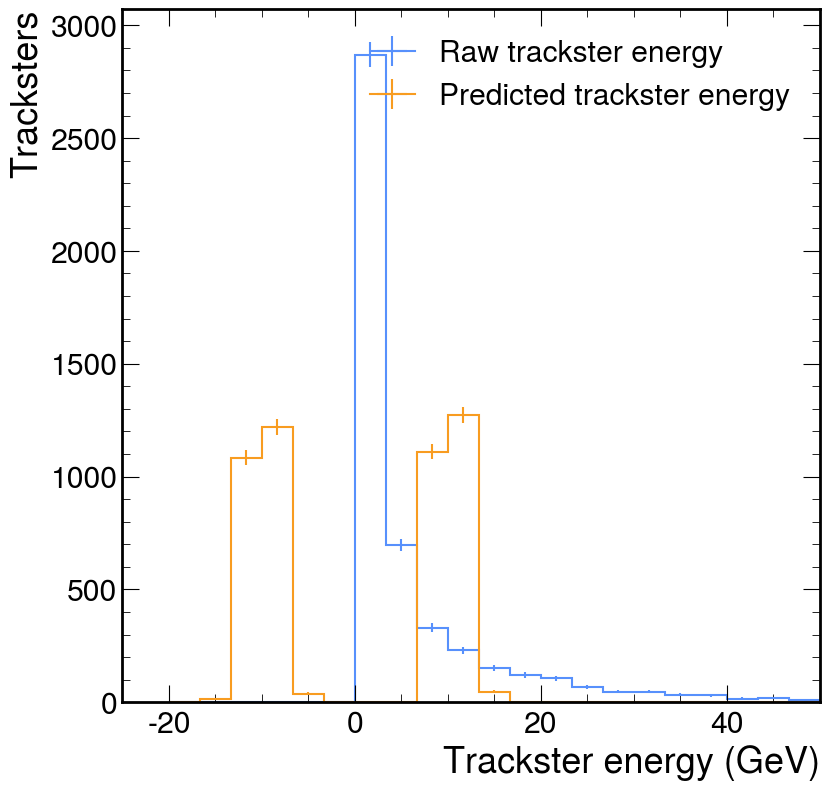

In [53]:
plt.figure(figsize=(9, 9))
hep.histplot([h_reco, h_pred], label=["Raw trackster energy", "Predicted trackster energy"])
# param_optimised,__name__ = fitCruijff(h_seedOverCP_energy)
# x_plotFct = np.linspace(h_seedOverCP_energy.axes[0].centers[0], h_seedOverCP_energy.axes[0].centers[-1],500)
# plt.plot(x_plotFct,cruijff(x_plotFct,*param_optimised), label=f"Cruijff fit\n$\sigma={(param_optimised[2]+param_optimised[3])/2:.3f}$")
plt.ylabel("Tracksters")
plt.xlabel("Trackster energy (GeV)")
plt.legend(loc="upper right")
plt.xlim(right=50)

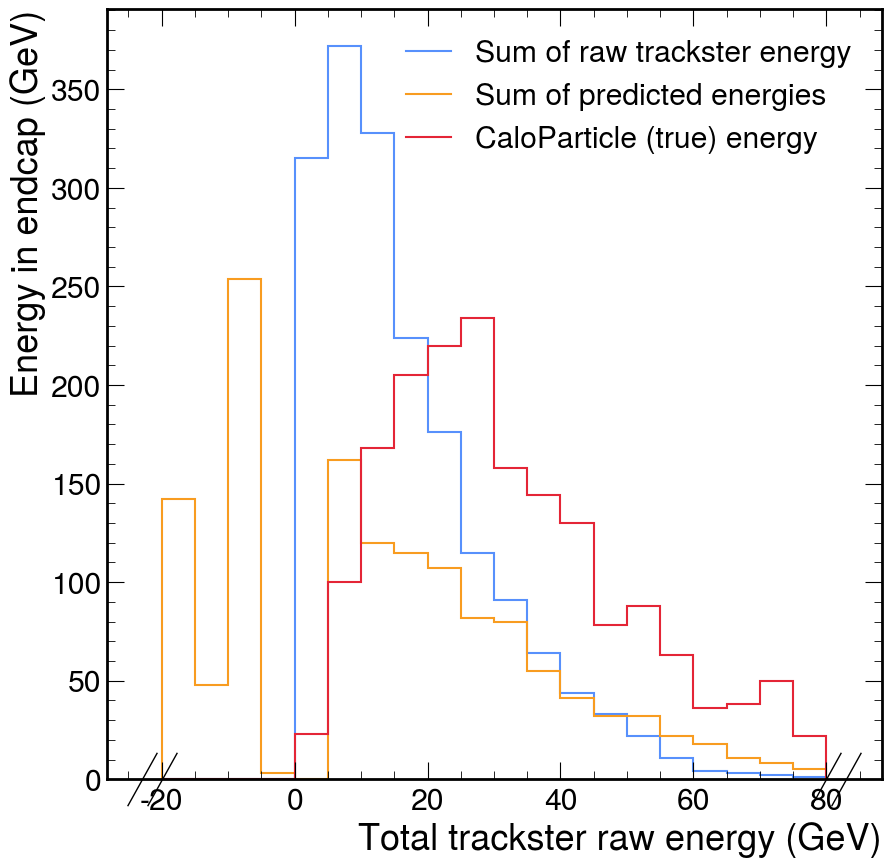

In [58]:
plt.figure()
hep.histplot([h_reco_tot, h_pred_tot, h_cp], yerr=False, label=["Sum of raw trackster energy", "Sum of predicted energies", "CaloParticle (true) energy"])
# param_optimised,__name__ = fitCruijff(h_seedOverCP_energy)
# x_plotFct = np.linspace(h_seedOverCP_energy.axes[0].centers[0], h_seedOverCP_energy.axes[0].centers[-1],500)
# plt.plot(x_plotFct,cruijff(x_plotFct,*param_optimised), label=f"Cruijff fit\n$\sigma={(param_optimised[2]+param_optimised[3])/2:.3f}$")
plt.ylabel("Events")
plt.ylabel("Energy in endcap (GeV)")
plt.legend()